# Understanding Dask behaviour in SpatialData

This notebook shows how you can more information on what SpatialData is doing under the hood and how Dask is scheduling computational tasks. For long-running pipelines using SpatialData or for heavy methods such as image operations, it can be useful to have **fine-grained performance metrics**. It may also be needed to **manage Dask worker resources** to reduce memory usage e.g. when segmenting using deep learning models such as cellpose.

For a more general overview, see [Understanding Performance in the Dask docs](https://docs.dask.org/en/latest/understanding-performance.html).

In [1]:
import spatialdata as sd
import dask
import dask.array as da
from dask.distributed import LocalCluster, span

/opt/homebrew/Caskroom/mambaforge/base/envs/harpy/lib/python3.10/site-packages/dask/dataframe/__init__.py:31: FutureWarning: The legacy Dask DataFrame implementation is deprecated and will be removed in a future version. Set the configuration option `dataframe.query-planning` to `True` or None to enable the new Dask Dataframe implementation and silence this warning.
  warnings.warn(
/opt/homebrew/Caskroom/mambaforge/base/envs/harpy/lib/python3.10/site-packages/numba/core/decorators.py:246: RuntimeWarning: nopython is set for njit and is ignored
  warnings.warn('nopython is set for njit and is ignored', RuntimeWarning)


The default [LocalCluster](https://distributed.dask.org/en/stable/api.html#cluster) sets up a Dask cluster with one worker per core, which can be too memory-intensive for some tasks.

Here we manually set the parameters of LocalCluster instead of the implicit Dask defaults for more control. Note the Dashboard URL, which you can open in a browser to see live monitoring of the Dask cluster. More information on the Dask dashboard can be found [here](https://docs.dask.org/en/latest/dashboard.html). If you wan to save the dashboard to a file, you can use a [Dask Performance Report](https://distributed.dask.org/en/latest/diagnosing-performance.html#performance-reports).

Here we set up a cluster with 1 worker and 1 thread per worker. We also limit the memory usage of each worker to a low amount (5GB), which is interesting when sharing a workstation with other users.

When working remotely, you can port forward the dask dashboard to your local machine with e.g. ssh -N -L 8787:localhost:8787 <remote_machine> and then access the dashboard at localhost:8787/status. Or use the [VS Code port forwarding functionality](https://code.visualstudio.com/docs/remote/ssh#_forwarding-a-port-creating-ssh-tunnel) for this.

In [2]:
# here we disable optimizations to make the code easier to understand, remove this line for better performance
dask.config.set({"optimization.fuse.active": False})

cluster = LocalCluster(
    # See [LocalCluster docs](https://distributed.dask.org/en/stable/api.html#cluster)
    # the number of workers to start
    n_workers=1,
    # the number of threads per worker, set to 1 to avoid oversubscription and only use Dask for parallelisation
    threads_per_worker=1,
    # the hard memory limit for *every* worker
    memory_limit="5GB",
    host="127.0.0.1",
    # see [Worker API docs](https://distributed.dask.org/en/stable/worker.html#api-documentation)
)
client = cluster.get_client()
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: http://127.0.0.1:8787/status,
Dashboard: http://127.0.0.1:8787/status,Workers: 1
Total threads: 1,Total memory: 4.66 GiB
Status: running,Using processes: True
Comm: tcp://127.0.0.1:57664,Workers: 1
Dashboard: http://127.0.0.1:8787/status,Total threads: 1
Started: Just now,Total memory: 4.66 GiB
Comm: tcp://127.0.0.1:57669,Total threads: 1
Dashboard: http://127.0.0.1:57670/status,Memory: 4.66 GiB
Nanny: tcp://127.0.0.1:57667,


## Workflow steps

Here we setup a workflow with the following steps:

1. Loading a large dataset
2. Applying two processing operations with map_raster (here a simple addition)

We use optional [Dask Spans](https://distributed.dask.org/en/stable/spans.html) to filter for more fine performance metrics in `Dashboard > More ... > Fine Performance Metrics`.

In [ ]:
def do_workflow():  # noqa: D103
    with span("my workflow"):
        with span("load data"):
            image_element = sd.models.Image2DModel.parse(
                da.random.random((3, 10_000, 10_000), chunks=(1, 1000, 1000)), dims="cyx"
            )
            # make sure the data is chunked to simulate a large image
            # sdata["blobs_image"] = sdata["blobs_image"].chunk(dict(c=1,  y=1_000, x=1_000))
        with span("process data"):
            # make sure we apply in a blockwise fashion
            step1_element = sd.map_raster(image_element, lambda x: x + 1, blockwise=True)
            step2_element = sd.map_raster(step1_element, lambda x: x + 2, blockwise=True)

    # compute the result
    step2_element.compute()
    # remove the result from memory
    client.cancel(step2_element)

In [4]:
cluster.scale(1)
cluster.wait_for_workers(1)

In [5]:
%%timeit -r 3 -n 1
do_workflow()

5.58 s ± 1.41 s per loop (mean ± std. dev. of 3 runs, 1 loop each)


In [6]:
cluster.scale(2)
cluster.wait_for_workers(2)

In [7]:
%%timeit -r 3 -n 1
do_workflow()

3.55 s ± 386 ms per loop (mean ± std. dev. of 3 runs, 1 loop each)


Depending in your machine, the workflow with one worker takes ~6 seconds, while the workflow with two workers uses ~4 seconds. Note that we don't get a perfect x2 speedup with x2 the number of workers, as there is some overhead setup for small examples.

Also note that more workers can lead to more memory usage, as we show here in this plot using the [dask.distributed.diagnostics.MemorySampler](https://distributed.dask.org/en/latest/diagnosing-performance.html?highlight=memory%20sampler#analysing-memory-usage-over-time).

<Axes: xlabel='time', ylabel='Cluster memory (GiB)'>

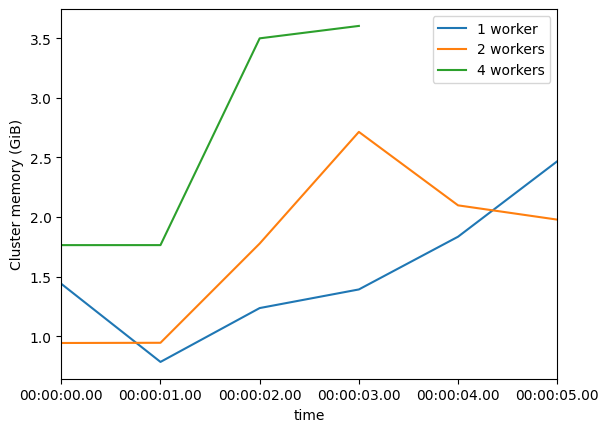

In [8]:
from distributed.diagnostics import MemorySampler

ms = MemorySampler()
cluster.scale(1)
cluster.wait_for_workers(1)
with ms.sample("1 worker"):
    do_workflow()
cluster.scale(2)
cluster.wait_for_workers(2)
with ms.sample("2 workers"):
    do_workflow()
cluster.scale(4)
cluster.wait_for_workers(4)
with ms.sample("4 workers"):
    do_workflow()
ms.plot(align=True)

- describe memory of task better for Dask
    - https://dask.discourse.group/t/specify-that-a-given-task-use-a-huge-amount-of-ram-to-the-dask-ressource-manager/1220
    
- limit workers manually
    - https://distributed.dask.org/en/stable/resources.html
    - https://distributed.dask.org/en/latest/locality.html#specify-workers-with-compute-persist